# Tensorflow Credit Card Fraud Detection

Hi! Mario Here! In this project I'll predict whether a credit card transaction is fraudulent or not. The dataset was obtained from Kaggle (https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/data) and consist of 30 features plus the class label.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, they cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise (this information appears on the URL above).

Let's first import some packages and load the dataset. The idea is to build a neural network using Tensorflow and Keras.

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import TomekLinks
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, auc, average_precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras

%matplotlib inline

import warnings

warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)

## Exploratory Data Analysis

In [2]:
df = pd.read_csv('creditcard.csv')
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


Now let's describe the data, and look if it have missing values, and if it is an imbalanced problem or not.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [4]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,2.239053e-15,1.673327e-15,-1.247012e-15,8.190001e-16,1.207294e-15,4.887456e-15,1.437716e-15,-3.772171e-16,9.564149e-16,1.039917e-15,6.406204e-16,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [5]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

The describe command by itself doesn't tell us much, as most features aren´t intuitive (I'll compare them later). Most of them have mean 0. The mean time is about 94,814 seconds since the first transaction, and the mean amount is about $88.35. They have a high standard deviation. Let's drop the duplicates.

In [6]:
# Lets drop duplicates
df.drop_duplicates(inplace = True)

df['Class'].value_counts()

Class
0    283253
1       473
Name: count, dtype: int64

As we can see, the problem is really imbalanced! 473 fraudulent transactions to 283,253 normal ones. So, for this problem, I'll probably use an ensemble model such as Random Forest, and the Area Under the Precision-Recall Curve as the main evaluation metric, because both tend to work well in the imbalanced case, unlike others. Besides, the PR AUC puts priority on the positive class, unlike the ROC AUC, which would be a little biased.

Let's see how the distributions over time for the transactions are. For that, I'll set the first transaction time to be the hour 00, and then measure by hour, from 00 to 23.

In [7]:
from datetime import timedelta

first_hour = pd.Timestamp('2024-01-01 00:00:00')

df['Hour'] = df['Time'].apply(lambda x: (first_hour + timedelta(seconds = x)).hour)

hours = df.groupby(['Class', 'Hour'])['Time'].count()

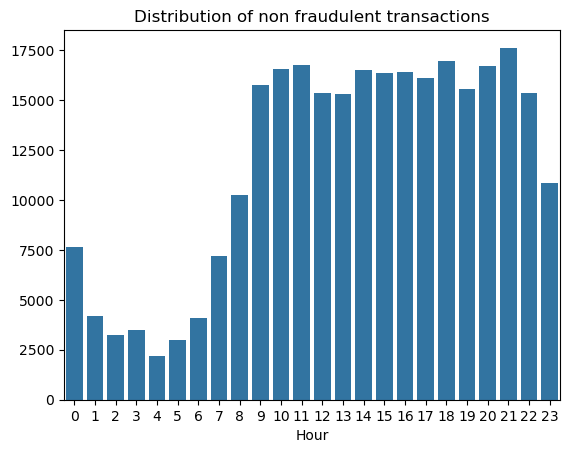

In [8]:
sns.barplot(x = hours[0].index, y = hours[0].values ).set(title = 'Distribution of non fraudulent transactions');
plt.show()

In [9]:
sns.barplot(x = hours[1].index, y = hours[1].values).set(title = 'Distribution of fraudulent transactions');

As we can see, in the non fraudulent cases the transactions increase from the hour 9 to 22, whereas in the fraudulent case they reach their peak in 2 specific hours: 2 and 11. We can't make good conclusions from this information, so I'll drop this feature and now compare the other features.

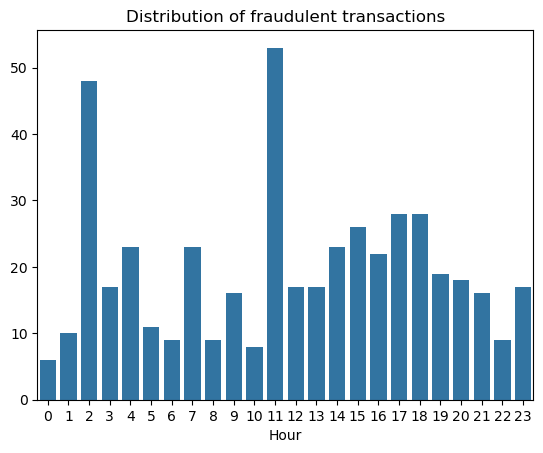

In [10]:
df = df.drop(['Time', 'Hour'], axis = 1)
plt.show()

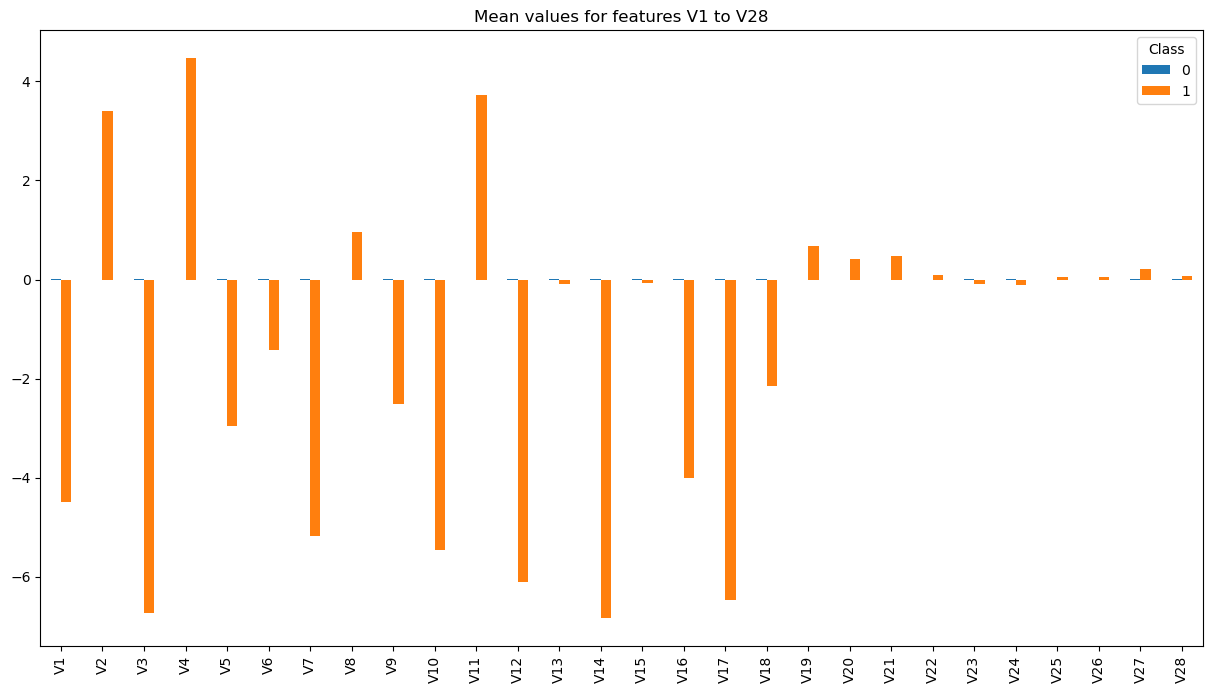

In [11]:

data = df.drop('Amount', axis = 1).groupby('Class').describe().xs(('mean'), level = 1, axis = 1)

data.T.plot(kind='bar', figsize=(15, 8));

plt.title('Mean values for features V1 to V28');

plt.show()

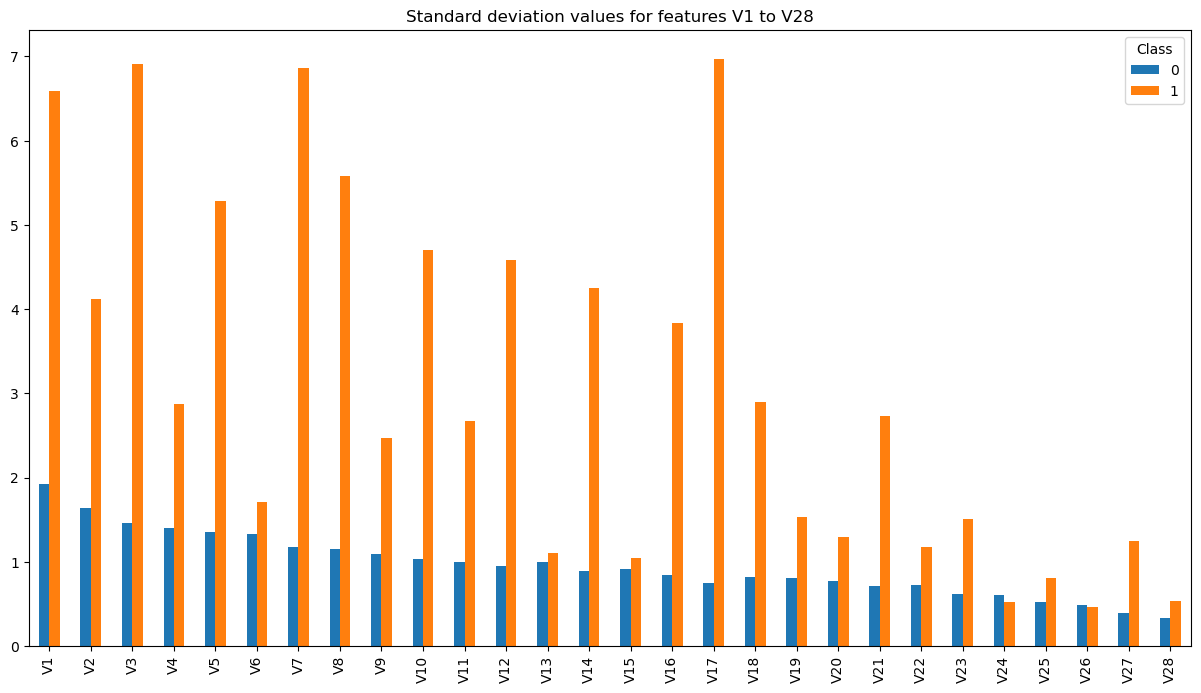

In [12]:

data = df.drop('Amount', axis = 1).groupby('Class').describe().xs(('std'), level = 1, axis = 1)

data.T.plot(kind='bar', figsize=(15, 8));

plt.title('Standard deviation values for features V1 to V28');

plt.show()

From the bar plots above we can see that, on average, the features values for non fraudulent transactions are around 0, whereas in the other case they are much greater or less than them, in almost all cases, especially V3, V12, V14 and V17. Also, the fraudulent cases have a much larger standard deviation. Let's now compare the Amount feature.

In [13]:
df.groupby('Class')['Amount'].describe()

,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
0,283253.0,88.413575,250.379023,0.0,5.67,22.00,77.46,25691.16
1,473.0,123.871860,260.211041,0.0,1.00,9.82,105.89,2125.87


As we can see, fraudulent transactions tend to have larger amounts of money involved on average, which is something someone might expect, although they have a high standard deviation and the maximum value is lower than class 0.

Let's study the correlations between variables. V1 to V28 are the components of a PCA, so they will be uncorrelated between them. Let's see what happens between Amount and the others.

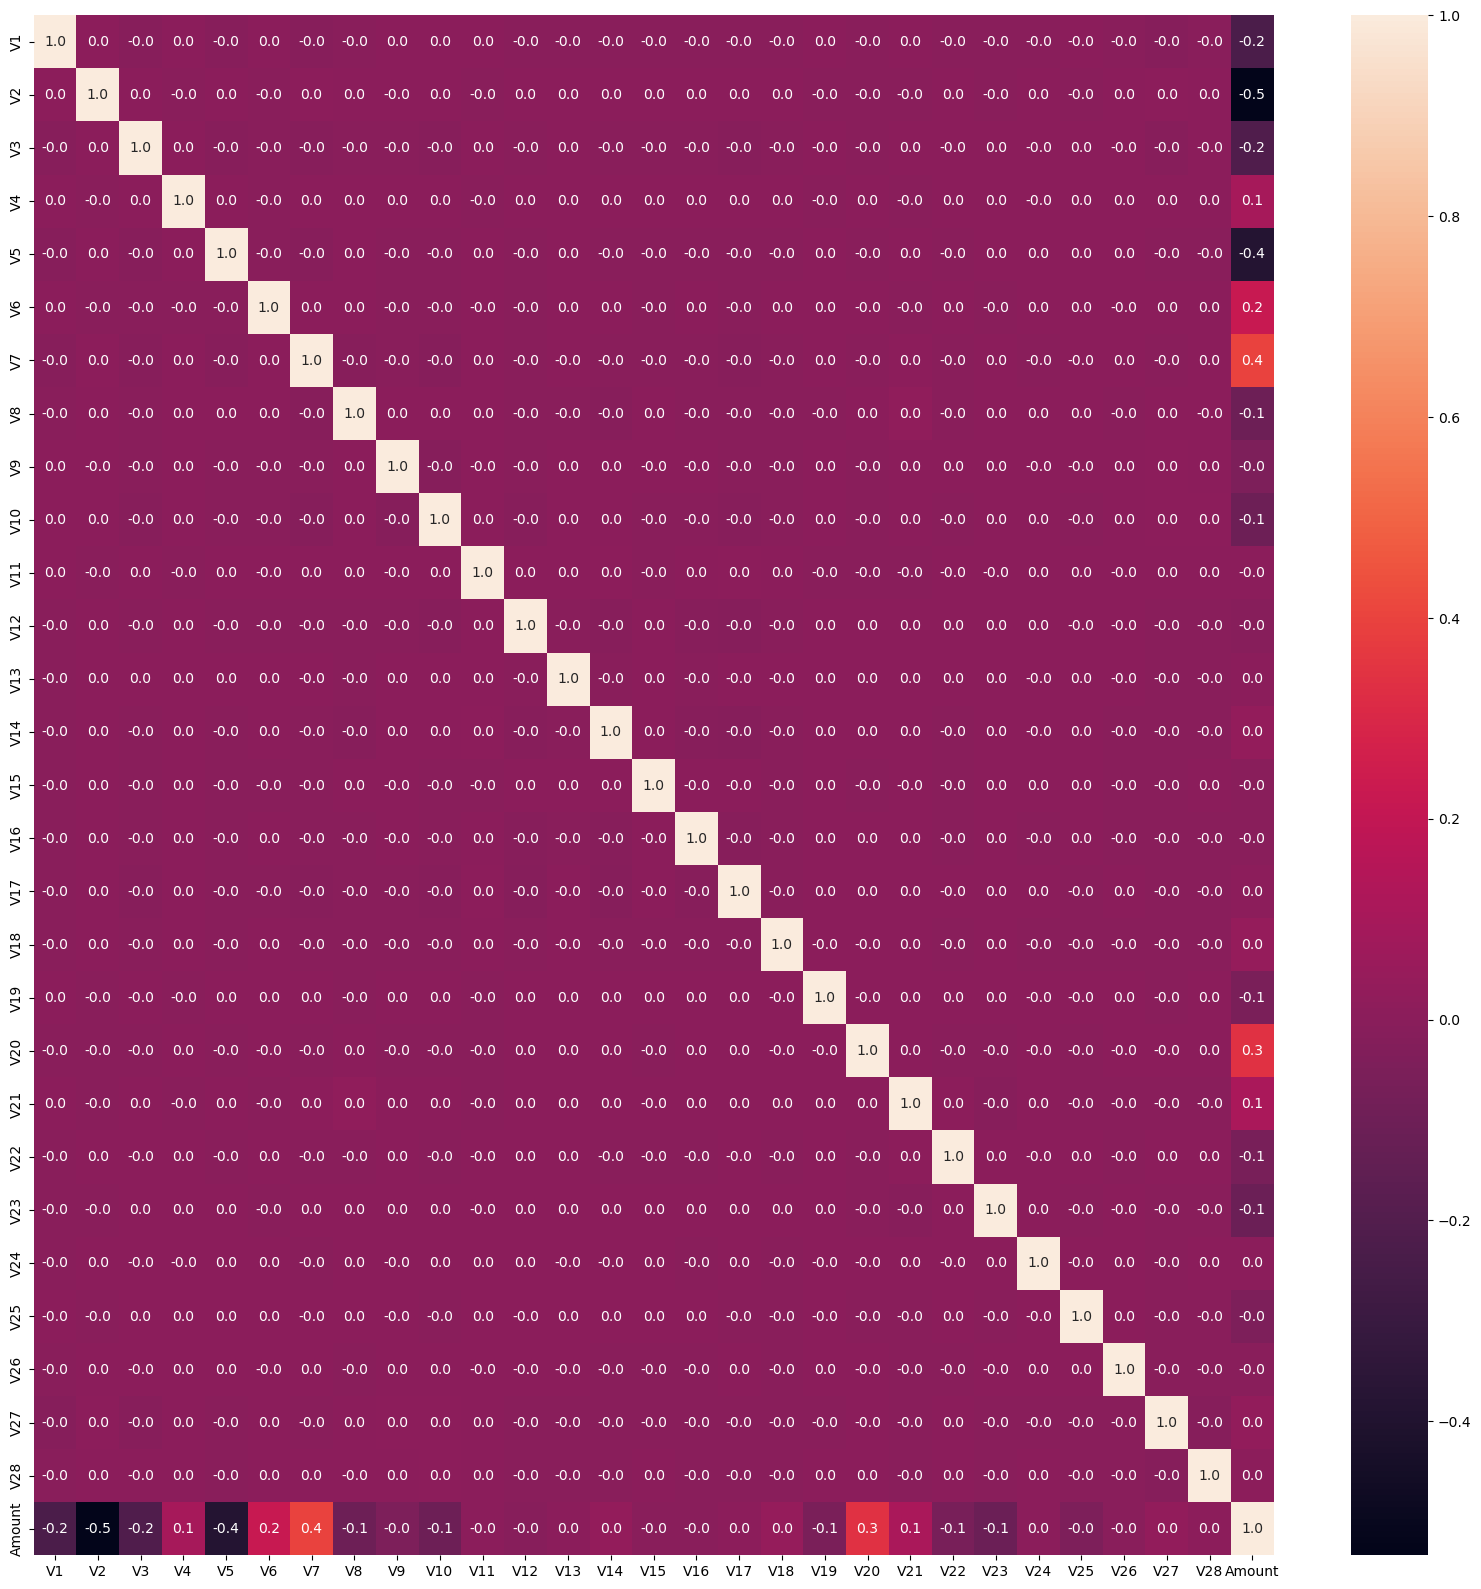

In [14]:
plt.figure(figsize = (20,20))
sns.heatmap(df.drop('Class', axis = 1).corr(), annot = True, fmt = '.1f');

plt.show()

We can see that the correlation between amount and the other features is in most cases close to 0, with the exception of V2, V5, V7 and V20. However, they aren't that high, so the strategy will be to build a neural network using Tensorflow and Keras.


## Model

Now I'll begin the steps to build the model. Because of the magnitude of the Amount, I'll apply a logarithm to it plus an epsilon to avoid an explosion if it is 0, and then split the dataset between the features and the target variable.

In [15]:
df['Amount'] = np.log(df['Amount'] + 0.001)

X = df.drop('Class', axis = 1)
y = df['Class']

Now I'll use a stratified kfold in order to have 3 different train and test sets.

In [16]:
skf = StratifiedKFold(n_splits = 3)

sets = []

for (train_index, test_index) in skf.split(X, y):
    sets.append((X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]))

X_train1 = sets[0][0]
X_test1 = sets[0][1]
y_train1 = sets[0][2]
y_test1 = sets[0][3]

X_train2 = sets[1][0]
X_test2 = sets[1][1]
y_train2 = sets[1][2]
y_test2 = sets[1][3]

X_train3 = sets[2][0]
X_test3 = sets[2][1]
y_train3 = sets[2][2]
y_test3 = sets[2][3]

Let's confirm that each set has a similar class proportion.

In [17]:
print(F'Proportion in train and test 1: {y_train1.mean():.4f} and {y_test1.mean():.4f}')
print(F'Proportion in train and test 2: {y_train2.mean():.4f} and {y_test2.mean():.4f}')
print(F'Proportion in train and test 3: {y_train3.mean():.4f} and {y_test3.mean():.4f}')

Proportion in train and test 1: 0.0017 and 0.0017
Proportion in train and test 2: 0.0017 and 0.0017
Proportion in train and test 3: 0.0017 and 0.0017


Ok, the proportions are the same, thanks to the stratified split. Let's transform the dataframes and series to numpy arrays, and standardize them, so that the neural network can work better.

In [18]:
scaler = StandardScaler()

X_train1 = scaler.fit_transform(np.array(X_train1))
X_test1 = scaler.transform(np.array(X_test1))

X_train2 = scaler.fit_transform(np.array(X_train2))
X_test2 = scaler.transform(np.array(X_test2))

X_train3 = scaler.fit_transform(np.array(X_train3))
X_test3 = scaler.transform(np.array(X_test3))

Now I'll begin creating the model. The main metrics will be the precision-recall AUC, the precision and recall. I'll include some others too. I chose the PR AUC because it gives more weight to the positive class instead of the ROC AUC. I'll use 3 layers, one with 16 hidden units and a ReLU activation function, a dropout layer for regularization, and a final layer with a sigmoid activation function. The loss function will be the binary cross-entropy. I'll add early stopping too.

In [85]:
METRICS = [
      keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

#Model with a He initializer and a dropout with 0.5 probability and Adam optimization algorithm
def make_model(metrics = METRICS):
    
    initializer = tf.keras.initializers.HeNormal(seed = 0)
    
    model = keras.Sequential([
        keras.layers.Dense(16, activation = 'relu', input_shape = (X_train1.shape[-1],), kernel_initializer = initializer),
        keras.layers.Dropout(0.6),
        keras.layers.Dense(1, activation='sigmoid', kernel_initializer = initializer),
    ])
    
    model.compile(
      optimizer = keras.optimizers.Adam(learning_rate = 0.001),
      loss = keras.losses.BinaryCrossentropy(),
      metrics = metrics)

    return model

Let's set the epochs to 100 and the batch size to 2048. It'll be a large number because we must make sure that the positive class gets some representation on each batch. Also, let's define the early stopping function.

In [86]:
EPOCHS = 100
BATCH_SIZE = 2048

def early_stopping():
    return tf.keras.callbacks.EarlyStopping(
        monitor = 'prc',
        verbose = 1,
        patience = 10,
        mode ='max',
        restore_best_weights = True)

In [87]:
model = make_model()
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 16)                480       
                                                                 
 dropout_6 (Dropout)         (None, 16)                0         
                                                                 
 dense_13 (Dense)            (None, 1)                 17        
                                                                 
Total params: 497
Trainable params: 497
Non-trainable params: 0
_________________________________________________________________


Now I'll train the model with the first training set (I'll use it as reference) and plot the training results.

In [88]:
history1 = model.fit(
    X_train1,
    y_train1,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    callbacks = [early_stopping()],
    verbose = 0)

Restoring model weights from the end of the best epoch: 25.
Epoch 35: early stopping


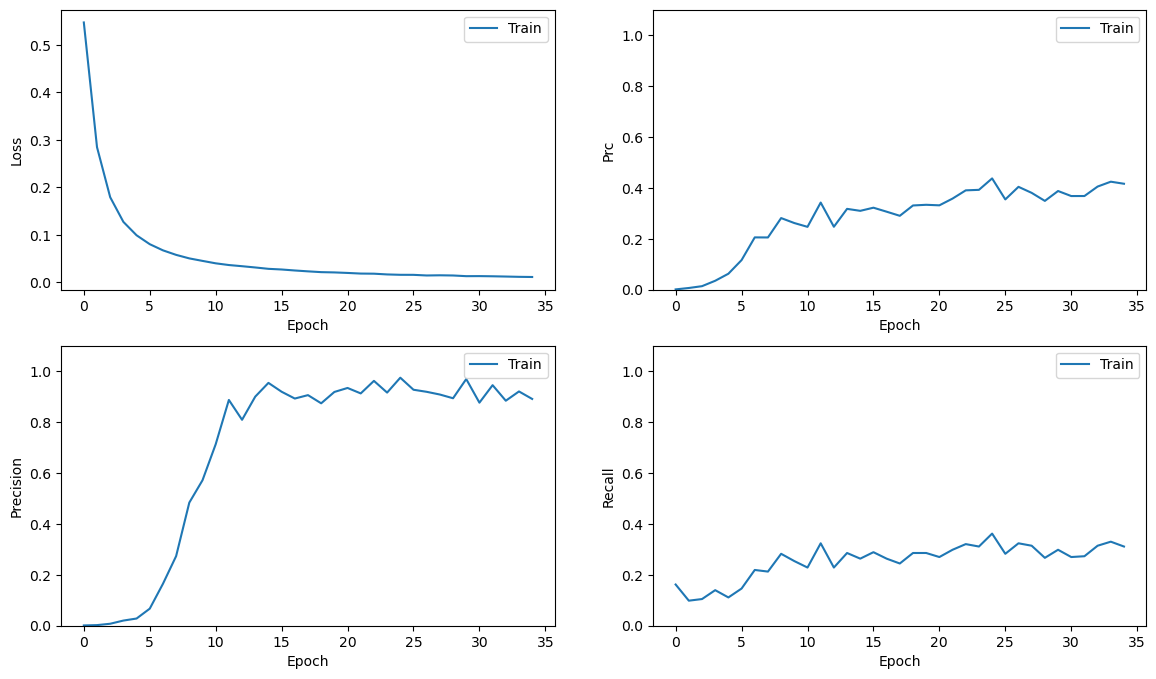

In [89]:
def plot_metrics(history):
    plt.figure(figsize = (14, 8))
    metrics = ['loss', 'prc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2, 2, n + 1)
        plt.plot(history.epoch, history.history[metric], label='Train')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([plt.ylim()[0], plt.ylim()[1]])

        else:
            plt.ylim([0,1.1])

        plt.legend()
    plt.show()

plot_metrics(history1)

Let's define a function to show the confusion matrix, and then show that and the metrics for the first train a test sets.

In [90]:
def plot_cm(labels, predictions, threshold = 0.5):
    cm = confusion_matrix(labels, predictions > threshold)
    plt.figure(figsize = (5, 5))
    sns.heatmap(cm, annot = True, fmt = "d")
    plt.title('Confusion matrix @{:.2f}'.format(threshold))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    
    plt.show()

In [91]:
train1_predictions = model.predict(X_train1, batch_size = BATCH_SIZE)
test1_predictions = model.predict(X_test1, batch_size = BATCH_SIZE)

train1_results = model.evaluate(X_train1, y_train1, batch_size = BATCH_SIZE, verbose = 0)
test1_results = model.evaluate(X_test1, y_test1, batch_size = BATCH_SIZE, verbose = 0)

print('Train 1 Results:')
for name, value in zip(model.metrics_names, train1_results):
    print(name, ': ', value)
print()

print('Test 1 Results:')
for name, value in zip(model.metrics_names, test1_results):
    print(name, ': ', value)

47/47 [==============================] - 0s 1ms/step
Train 1 Results:
loss :  0.004105182830244303
cross entropy :  0.004105182830244303
tp :  211.0
fp :  11.0
tn :  188824.0
fn :  104.0
accuracy :  0.999392032623291
precision :  0.9504504799842834
recall :  0.6698412895202637
auc :  0.8934327363967896
prc :  0.752275824546814

Test 1 Results:
loss :  0.003264785511419177
cross entropy :  0.003264785511419177
tp :  124.0
fp :  37.0
tn :  94381.0
fn :  34.0
accuracy :  0.999249279499054
precision :  0.7701863646507263
recall :  0.7848101258277893
auc :  0.9615796804428101
prc :  0.7407890558242798


We can see that we obtain a decent precision, although we would like the recall to be higher. The PR AUC could be considered as acceptable. We can also see the components of the confusion matrix above. Let's calculate the accuracy,  precision and recall when changing the threshold to 0.1 and 0.01

In [92]:
test1_predictions_01 = (test1_predictions > 0.1).astype(int)
test1_predictions_001 = (test1_predictions > 0.01).astype(int)


print('Threshold = 0.1:')
print('Accuracy: ', accuracy_score(y_test1, test1_predictions_01))
print('Precision: ', precision_score(y_test1, test1_predictions_01))
print('Recall: ', recall_score(y_test1, test1_predictions_01))
print('')
print('Threshold = 0.01:')
print('Accuracy: ', accuracy_score(y_test1, test1_predictions_001))
print('Precision: ', precision_score(y_test1, test1_predictions_001))
print('Recall: ', recall_score(y_test1, test1_predictions_001))

Threshold = 0.1:
Accuracy:  0.9992492810015225
Precision:  0.7485714285714286
Recall:  0.8291139240506329

Threshold = 0.01:
Accuracy:  0.9977055489764846
Precision:  0.4144927536231884
Recall:  0.9050632911392406


With a threshold of 0.01 the recall improves to almost 0.91, and the precision is reduced to 0.41. This is a good recall and, whereas the precision has been been reduced a lot, not everything is a false positive. So, this is a better scenario. Let's see the confusion matrix. 

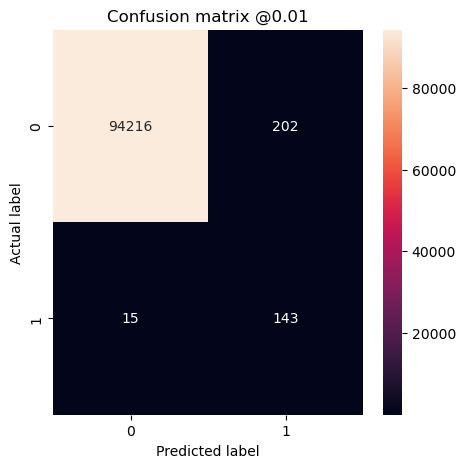

In [93]:
plot_cm(y_test1, test1_predictions, 0.01)

Now let's see what happens if I use balanced classes.

In [110]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.

total = y.shape[0]
pos = y.sum()
neg = total - pos

weight_for_0 = (1 / neg) * (total / 2.0)
#weight_for_1 = (1 / pos) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0) - 275

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 24.92


In [111]:
balanced_history = model.fit(
    X_train1,
    y_train1,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    callbacks = [early_stopping()],
    verbose = 0,
    class_weight = class_weight)

Restoring model weights from the end of the best epoch: 8.
Epoch 18: early stopping


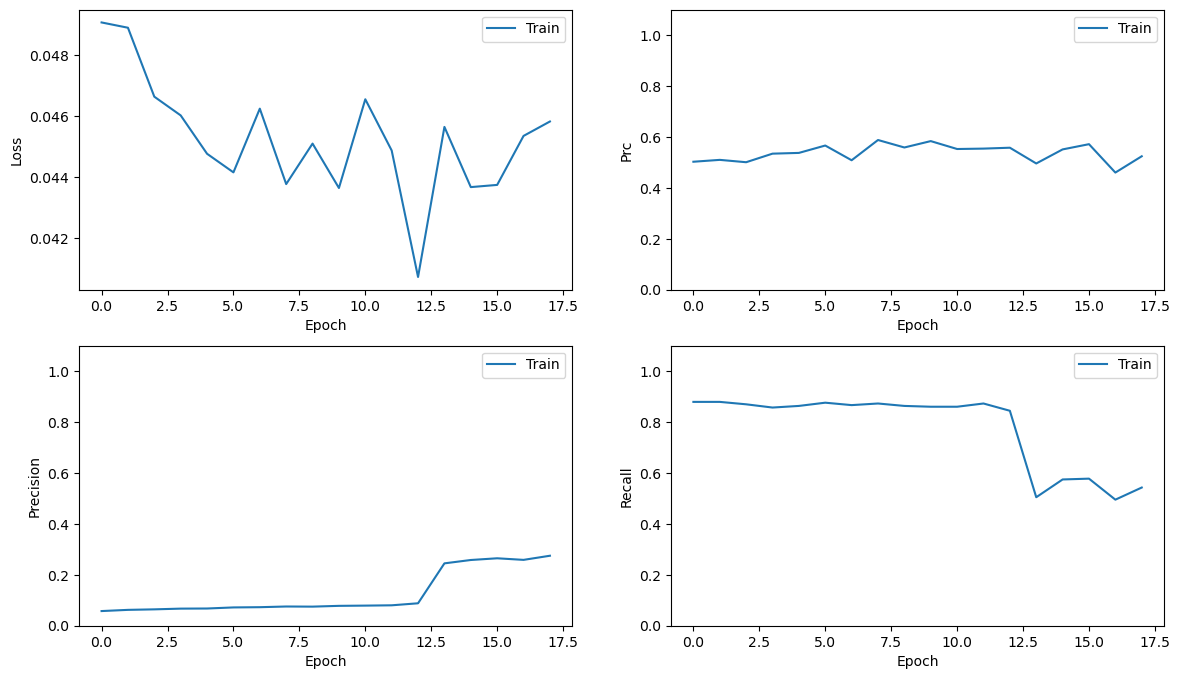

In [112]:
plot_metrics(balanced_history)

In [113]:
train1_predictions_balanced = model.predict(X_train1, batch_size = BATCH_SIZE)
test1_predictions_balanced = model.predict(X_test1, batch_size = BATCH_SIZE)

train1_results_balanced = model.evaluate(X_train1, y_train1, batch_size = BATCH_SIZE, verbose = 0)
test1_results_balanced = model.evaluate(X_test1, y_test1, batch_size = BATCH_SIZE, verbose = 0)

print('Train 1 Results:')
for name, value in zip(model.metrics_names, train1_results_balanced):
    print(name, ': ', value)
print()

print('Test 1 Results:')
for name, value in zip(model.metrics_names, test1_results_balanced):
    print(name, ': ', value)

47/47 [==============================] - 0s 1ms/step
Train 1 Results:
loss :  0.008860163390636444
cross entropy :  0.008860163390636444
tp :  270.0
fp :  225.0
tn :  188610.0
fn :  45.0
accuracy :  0.998572587966919
precision :  0.5454545617103577
recall :  0.8571428656578064
auc :  0.9892176985740662
prc :  0.8175163865089417

Test 1 Results:
loss :  0.015341315418481827
cross entropy :  0.015341315418481827
tp :  145.0
fp :  145.0
tn :  94273.0
fn :  13.0
accuracy :  0.9983294010162354
precision :  0.5
recall :  0.9177215099334717
auc :  0.9898099899291992
prc :  0.71281898021698


We can see that with balanced classes our recall is really good, but the precision is almost 0, and we don't want to be calling people and telling them they have commited fraud with their credit card. Let's see what happens when I change the weight for class 1 to 25. 

In [ ]:
weight_for_1 = (1 / pos) * (total / 2.0) - 275

class_weight = {0: weight_for_0, 1: weight_for_1}

In [ ]:
balanced_history = model.fit(
    X_train1,
    y_train1,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    callbacks = [early_stopping()],
    verbose = 0,
    class_weight = class_weight)

In [114]:

train1_results_balanced = model.evaluate(X_train1, y_train1, batch_size = BATCH_SIZE, verbose = 0)
test1_results_balanced = model.evaluate(X_test1, y_test1, batch_size = BATCH_SIZE, verbose = 0)

print('Train 1 Results:')
for name, value in zip(model.metrics_names, train1_results_balanced):
    print(name, ': ', value)
print()

print('Test 1 Results:')
for name, value in zip(model.metrics_names, test1_results_balanced):
    print(name, ': ', value)

Train 1 Results:
loss :  0.008860163390636444
cross entropy :  0.008860163390636444
tp :  270.0
fp :  225.0
tn :  188610.0
fn :  45.0
accuracy :  0.998572587966919
precision :  0.5454545617103577
recall :  0.8571428656578064
auc :  0.9892176985740662
prc :  0.8175163865089417

Test 1 Results:
loss :  0.015341315418481827
cross entropy :  0.015341315418481827
tp :  145.0
fp :  145.0
tn :  94273.0
fn :  13.0
accuracy :  0.9983294010162354
precision :  0.5
recall :  0.9177215099334717
auc :  0.9898099899291992
prc :  0.71281898021698


We improved the precision and recall with these weights! So this model seems to be better when using the first training and test sets. Let's now use the others and calculate the average.

In [115]:
balanced_history2 = model.fit(
    X_train2,
    y_train2,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    callbacks = [early_stopping()],
    verbose = 0,
    class_weight = class_weight)

Restoring model weights from the end of the best epoch: 6.
Epoch 16: early stopping


In [116]:

train2_results_balanced = model.evaluate(X_train2, y_train2, batch_size = BATCH_SIZE, verbose = 0)
test2_results_balanced = model.evaluate(X_test2, y_test2, batch_size = BATCH_SIZE, verbose = 0)

print('Train 2 Results:')
for name, value in zip(model.metrics_names, train2_results_balanced):
    print(name, ': ', value)
print()

print('Test 2 Results:')
for name, value in zip(model.metrics_names, test2_results_balanced):
    print(name, ': ', value)

Train 2 Results:
loss :  0.008368626236915588
cross entropy :  0.008368626236915588
tp :  282.0
fp :  156.0
tn :  188679.0
fn :  34.0
accuracy :  0.9989954829216003
precision :  0.6438356041908264
recall :  0.892405092716217
auc :  0.9923067688941956
prc :  0.7406928539276123

Test 2 Results:
loss :  0.00778320012614131
cross entropy :  0.00778320012614131
tp :  128.0
fp :  87.0
tn :  94331.0
fn :  29.0
accuracy :  0.998773455619812
precision :  0.5953488349914551
recall :  0.8152866363525391
auc :  0.9702720046043396
prc :  0.7850055694580078


In [117]:
balanced_history3 = model.fit(
    X_train3,
    y_train3,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    callbacks = [early_stopping()],
    verbose = 0,
    class_weight = class_weight)

Restoring model weights from the end of the best epoch: 3.
Epoch 13: early stopping


In [118]:
train3_results_balanced = model.evaluate(X_train3, y_train3, batch_size = BATCH_SIZE, verbose = 0)
test3_results_balanced = model.evaluate(X_test3, y_test3, batch_size = BATCH_SIZE, verbose = 0)

print('Train 3 Results:')
for name, value in zip(model.metrics_names, train3_results_balanced):
    print(name, ': ', value)
print()

print('Test 3 Results:')
for name, value in zip(model.metrics_names, test3_results_balanced):
    print(name, ': ', value)

Train 3 Results:
loss :  0.008851238526403904
cross entropy :  0.008851238526403904
tp :  276.0
fp :  144.0
tn :  188692.0
fn :  39.0
accuracy :  0.9990324974060059
precision :  0.6571428775787354
recall :  0.8761904835700989
auc :  0.9806984066963196
prc :  0.7333810329437256

Test 3 Results:
loss :  0.0058471690863370895
cross entropy :  0.0058471690863370895
tp :  134.0
fp :  78.0
tn :  94339.0
fn :  24.0
accuracy :  0.9989215135574341
precision :  0.6320754885673523
recall :  0.8481012582778931
auc :  0.9900873899459839
prc :  0.8513683080673218


In [124]:
print('Results of Cross-Validation:')
print('Precision = ', (test1_results_balanced[7] + test2_results_balanced[7] + test3_results_balanced[7]) / 3)
print('Recall = ', (test1_results_balanced[8] + test2_results_balanced[8] + test3_results_balanced[8]) / 3)
print('PR AUC = ', (test1_results_balanced[10] + test2_results_balanced[10] + test3_results_balanced[10]) / 3)

Results of Cross-Validation:
Precision =  0.5758081078529358
Recall =  0.8603698015213013
PR AUC =  0.7830642859141032


Using Cross-Validation, we obtain a quite decent model, with a 0.57 precision, 0.86 recall and 0.78 PR AUC. So we won't have many false negatives or false positives, although there will be more of the second ones. And if I need to increase the recall, I could change the threshold again.